## Leiden Clustering Cell-Tag

### 7-21

In [1]:
import numpy as np
import anndata as ad
import pandas as pd
import os
import numpy as np
import sys
import scanpy as sc

In [2]:
# Define the path to the main folder
main_folder = "/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/main_semi_test"

# Add it to sys.path
sys.path.append(main_folder)

from LCL_eval_final import LCL_Eval
from collections import Counter

### lambda 0.01

In [21]:
INPUT_DIR  = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Larry_top200/grid_search_testAsPenalty_1"
TRAIN_ANND = "/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_train.h5ad"
TEST_ANND  = "/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_test.h5ad"

adata_train = ad.read_h5ad(TRAIN_ANND)
adata_test  = ad.read_h5ad(TEST_ANND)
train_labels = adata_train.obs["clone_id"].to_numpy()
test_labels  = adata_test.obs["clone_id"].to_numpy()

train_emb = np.load(os.path.join(INPUT_DIR, "lambda0.01_unlab15_bs150/scBaseEncoderFeat_Z_bs150_tau0.5.npy"))
test_emb  = np.load(os.path.join(INPUT_DIR, "lambda0.01_unlab15_bs150/test_embedding.npy"))

tr = adata_train.copy()
te = adata_test.copy()
tr.obsm["X_lcl"] = train_emb
te.obsm["X_lcl"] = test_emb
tr.obs["dataset"] = "train"
te.obs["dataset"] = "test"
adata_all = sc.concat([tr, te], axis=0, join="outer")

In [22]:
# Leiden clustering
sc.pp.neighbors(adata_all, use_rep="X_lcl", n_neighbors=15)
sc.tl.umap(adata_all)
sc.tl.leiden(adata_all, resolution=0.01, key_added="lcl_leiden")

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


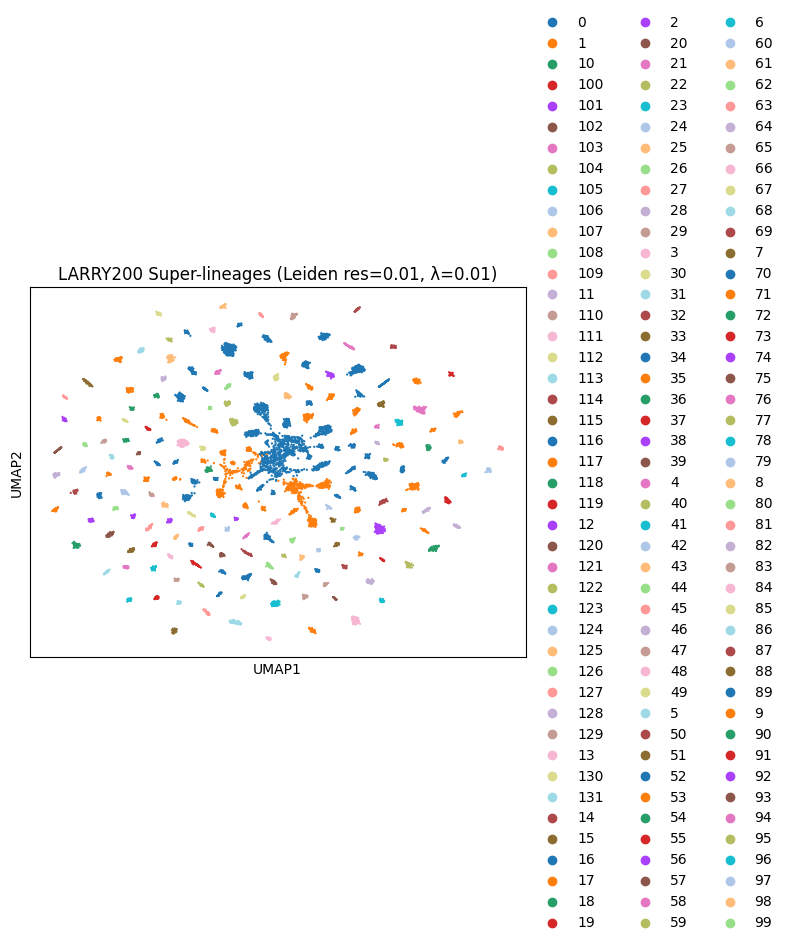

In [23]:
adata_all.obs["lcl_leiden"] = (
    adata_all.obs["lcl_leiden"]
    .astype(str)       
    .astype("category")
)

sc.pl.umap(
    adata_all,
    color="lcl_leiden",
    palette=sc.pl.palettes.default_20,   # only up to 20 colors
    legend_loc="right margin",
    title="LARRY200 Super-lineages (Leiden res=0.01, λ=0.01)"
)

In [24]:
# 5) cluster‐by‐dataset cross‐tab
ct = (
    adata_all.obs
    .groupby(["lcl_leiden", "dataset"])
    .size()
    .unstack(fill_value=0)
)
ct["total"] = ct.sum(axis=1)
ct = ct.sort_values("total", ascending=False)

# ← fix: wrap the & in parentheses so .sum() applies to the combined mask
n_clusters     = adata_all.obs["lcl_leiden"].nunique()
clusters_both  = ((ct["train"] > 0) & (ct["test"] > 0)).sum()
clusters_train = ((ct["train"] > 0) & (ct["test"] == 0)).sum()
clusters_test  = ((ct["train"] == 0) & (ct["test"] > 0)).sum()

# 6) per‐lineage cluster occupancy
lineage_groups = (
    adata_all.obs[["clone_id", "lcl_leiden"]]
    .drop_duplicates()
    .groupby("clone_id")["lcl_leiden"]
    .nunique()
)
n_lineages           = lineage_groups.shape[0]
lineages_one_cluster = (lineage_groups == 1).sum()
prop_one_cluster     = lineages_one_cluster / n_lineages

# 7) print summary
print(f"Total Leiden clusters:           {n_clusters}")
print(f"Clusters with both train & test:  {clusters_both}")
print(f"Clusters train‐only:             {clusters_train}")
print(f"Clusters test‐only:              {clusters_test}")
print()
print(f"Total lineages:                  {n_lineages}")
print(f"Lineages in exactly one cluster: {lineages_one_cluster} ({prop_one_cluster:.2%})")

Total Leiden clusters:           132
Clusters with both train & test:  11
Clusters train‐only:             121
Clusters test‐only:              0

Total lineages:                  200
Lineages in exactly one cluster: 58 (29.00%)


/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_4031/1083807402.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_all.obs


### lambda 0.1

In [12]:
INPUT_DIR  = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Larry_top200/grid_search_testAsPenalty_1"
TRAIN_ANND = "/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_train.h5ad"
TEST_ANND  = "/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_test.h5ad"

adata_train = ad.read_h5ad(TRAIN_ANND)
adata_test  = ad.read_h5ad(TEST_ANND)
train_labels = adata_train.obs["clone_id"].to_numpy()
test_labels  = adata_test.obs["clone_id"].to_numpy()

train_emb = np.load(os.path.join(INPUT_DIR, "lambda0.1_unlab15_bs150/scBaseEncoderFeat_Z_bs150_tau0.5.npy"))
test_emb  = np.load(os.path.join(INPUT_DIR, "lambda0.1_unlab15_bs150/test_embedding.npy"))

tr = adata_train.copy()
te = adata_test.copy()
tr.obsm["X_lcl"] = train_emb
te.obsm["X_lcl"] = test_emb
tr.obs["dataset"] = "train"
te.obs["dataset"] = "test"
adata_all = sc.concat([tr, te], axis=0, join="outer")

In [13]:
# Leiden clustering
sc.pp.neighbors(adata_all, use_rep="X_lcl", n_neighbors=15)
sc.tl.umap(adata_all)
sc.tl.leiden(adata_all, resolution=0.01, key_added="lcl_leiden")

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


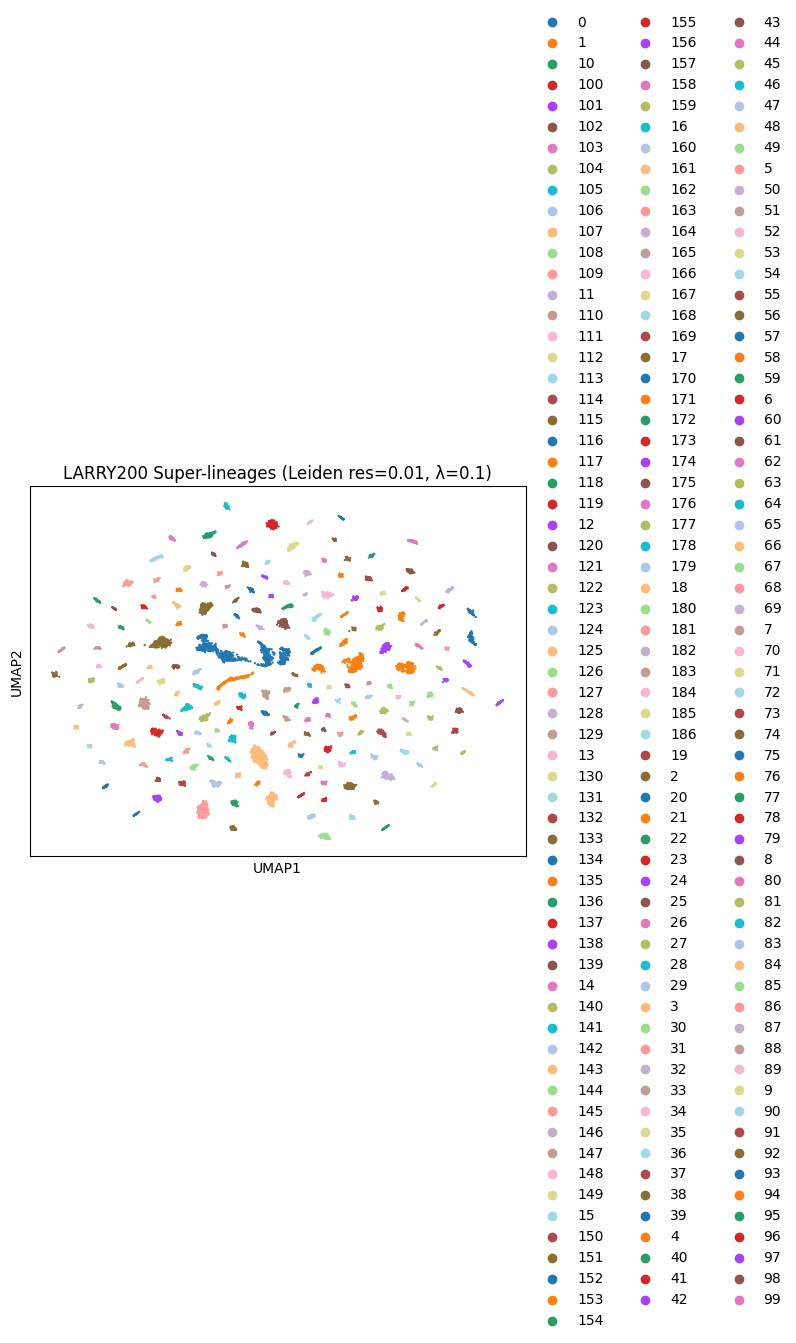

In [15]:
adata_all.obs["lcl_leiden"] = (
    adata_all.obs["lcl_leiden"]
    .astype(str)       
    .astype("category")
)

sc.pl.umap(
    adata_all,
    color="lcl_leiden",
    palette=sc.pl.palettes.default_20,   # only up to 20 colors
    legend_loc="right margin",
    title="LARRY200 Super-lineages (Leiden res=0.01, λ=0.1)"
)

In [16]:
# 5) cluster‐by‐dataset cross‐tab
ct = (
    adata_all.obs
    .groupby(["lcl_leiden", "dataset"])
    .size()
    .unstack(fill_value=0)
)
ct["total"] = ct.sum(axis=1)
ct = ct.sort_values("total", ascending=False)

# ← fix: wrap the & in parentheses so .sum() applies to the combined mask
n_clusters     = adata_all.obs["lcl_leiden"].nunique()
clusters_both  = ((ct["train"] > 0) & (ct["test"] > 0)).sum()
clusters_train = ((ct["train"] > 0) & (ct["test"] == 0)).sum()
clusters_test  = ((ct["train"] == 0) & (ct["test"] > 0)).sum()

# 6) per‐lineage cluster occupancy
lineage_groups = (
    adata_all.obs[["clone_id", "lcl_leiden"]]
    .drop_duplicates()
    .groupby("clone_id")["lcl_leiden"]
    .nunique()
)
n_lineages           = lineage_groups.shape[0]
lineages_one_cluster = (lineage_groups == 1).sum()
prop_one_cluster     = lineages_one_cluster / n_lineages

# 7) print summary
print(f"Total Leiden clusters:           {n_clusters}")
print(f"Clusters with both train & test:  {clusters_both}")
print(f"Clusters train‐only:             {clusters_train}")
print(f"Clusters test‐only:              {clusters_test}")
print()
print(f"Total lineages:                  {n_lineages}")
print(f"Lineages in exactly one cluster: {lineages_one_cluster} ({prop_one_cluster:.2%})")

Total Leiden clusters:           187
Clusters with both train & test:  4
Clusters train‐only:             183
Clusters test‐only:              0

Total lineages:                  200
Lineages in exactly one cluster: 5 (2.50%)


/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_4031/1083807402.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_all.obs


### lambda 0.5

In [30]:
INPUT_DIR  = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Larry_top200/grid_search_testAsPenalty_1"
TRAIN_ANND = "/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_train.h5ad"
TEST_ANND  = "/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_test.h5ad"

adata_train = ad.read_h5ad(TRAIN_ANND)
adata_test  = ad.read_h5ad(TEST_ANND)
train_labels = adata_train.obs["clone_id"].to_numpy()
test_labels  = adata_test.obs["clone_id"].to_numpy()

train_emb = np.load(os.path.join(INPUT_DIR, "lambda0.5_unlab15_bs150/scBaseEncoderFeat_Z_bs150_tau0.5.npy"))
test_emb  = np.load(os.path.join(INPUT_DIR, "lambda0.5_unlab15_bs150/test_embedding.npy"))

tr = adata_train.copy()
te = adata_test.copy()
tr.obsm["X_lcl"] = train_emb
te.obsm["X_lcl"] = test_emb
tr.obs["dataset"] = "train"
te.obs["dataset"] = "test"
adata_all = sc.concat([tr, te], axis=0, join="outer")

In [31]:
# Leiden clustering
sc.pp.neighbors(adata_all, use_rep="X_lcl", n_neighbors=15)
sc.tl.umap(adata_all)
sc.tl.leiden(adata_all, resolution=0.01, key_added="lcl_leiden")

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


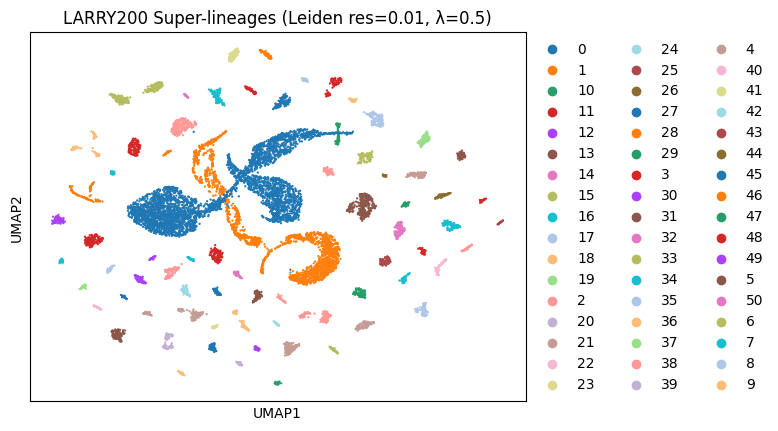

In [32]:
adata_all.obs["lcl_leiden"] = (
    adata_all.obs["lcl_leiden"]
    .astype(str)       
    .astype("category")
)

sc.pl.umap(
    adata_all,
    color="lcl_leiden",
    palette=sc.pl.palettes.default_20,   # only up to 20 colors
    legend_loc="right margin",
    title="LARRY200 Super-lineages (Leiden res=0.01, λ=0.5)"
)

In [33]:
# 5) cluster‐by‐dataset cross‐tab
ct = (
    adata_all.obs
    .groupby(["lcl_leiden", "dataset"])
    .size()
    .unstack(fill_value=0)
)
ct["total"] = ct.sum(axis=1)
ct = ct.sort_values("total", ascending=False)

# ← fix: wrap the & in parentheses so .sum() applies to the combined mask
n_clusters     = adata_all.obs["lcl_leiden"].nunique()
clusters_both  = ((ct["train"] > 0) & (ct["test"] > 0)).sum()
clusters_train = ((ct["train"] > 0) & (ct["test"] == 0)).sum()
clusters_test  = ((ct["train"] == 0) & (ct["test"] > 0)).sum()

# 6) per‐lineage cluster occupancy
lineage_groups = (
    adata_all.obs[["clone_id", "lcl_leiden"]]
    .drop_duplicates()
    .groupby("clone_id")["lcl_leiden"]
    .nunique()
)
n_lineages           = lineage_groups.shape[0]
lineages_one_cluster = (lineage_groups == 1).sum()
prop_one_cluster     = lineages_one_cluster / n_lineages

# 7) print summary
print(f"Total Leiden clusters:           {n_clusters}")
print(f"Clusters with both train & test:  {clusters_both}")
print(f"Clusters train‐only:             {clusters_train}")
print(f"Clusters test‐only:              {clusters_test}")
print()
print(f"Total lineages:                  {n_lineages}")
print(f"Lineages in exactly one cluster: {lineages_one_cluster} ({prop_one_cluster:.2%})")

Total Leiden clusters:           51
Clusters with both train & test:  11
Clusters train‐only:             40
Clusters test‐only:              0

Total lineages:                  200
Lineages in exactly one cluster: 49 (24.50%)


/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_4031/1083807402.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_all.obs


### lambda 1

In [26]:
INPUT_DIR  = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Larry_top200/grid_search_testAsPenalty_1"
TRAIN_ANND = "/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_train.h5ad"
TEST_ANND  = "/Users/apple/Desktop/KB/data/LarryData/train_test/Larry_200_test.h5ad"

adata_train = ad.read_h5ad(TRAIN_ANND)
adata_test  = ad.read_h5ad(TEST_ANND)
train_labels = adata_train.obs["clone_id"].to_numpy()
test_labels  = adata_test.obs["clone_id"].to_numpy()

train_emb = np.load(os.path.join(INPUT_DIR, "lambda1.0_unlab15_bs150/scBaseEncoderFeat_Z_bs150_tau0.5.npy"))
test_emb  = np.load(os.path.join(INPUT_DIR, "lambda1.0_unlab15_bs150/test_embedding.npy"))

tr = adata_train.copy()
te = adata_test.copy()
tr.obsm["X_lcl"] = train_emb
te.obsm["X_lcl"] = test_emb
tr.obs["dataset"] = "train"
te.obs["dataset"] = "test"
adata_all = sc.concat([tr, te], axis=0, join="outer")

In [27]:
# Leiden clustering
sc.pp.neighbors(adata_all, use_rep="X_lcl", n_neighbors=15)
sc.tl.umap(adata_all)
sc.tl.leiden(adata_all, resolution=0.01, key_added="lcl_leiden")

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


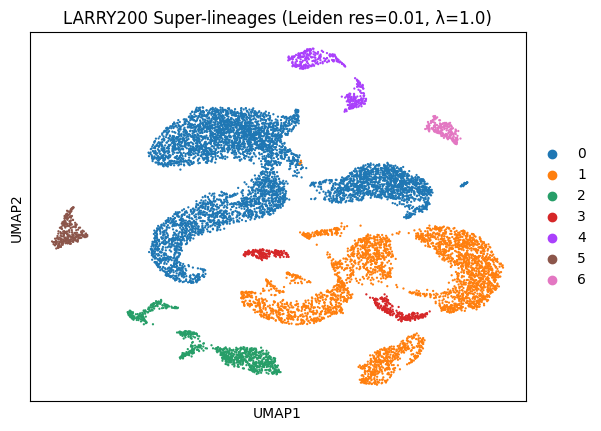

In [28]:
adata_all.obs["lcl_leiden"] = (
    adata_all.obs["lcl_leiden"]
    .astype(str)       
    .astype("category")
)

sc.pl.umap(
    adata_all,
    color="lcl_leiden",
    palette=sc.pl.palettes.default_20,   # only up to 20 colors
    legend_loc="right margin",
    title="LARRY200 Super-lineages (Leiden res=0.01, λ=1.0)"
)

In [29]:
# 5) cluster‐by‐dataset cross‐tab
ct = (
    adata_all.obs
    .groupby(["lcl_leiden", "dataset"])
    .size()
    .unstack(fill_value=0)
)
ct["total"] = ct.sum(axis=1)
ct = ct.sort_values("total", ascending=False)

# ← fix: wrap the & in parentheses so .sum() applies to the combined mask
n_clusters     = adata_all.obs["lcl_leiden"].nunique()
clusters_both  = ((ct["train"] > 0) & (ct["test"] > 0)).sum()
clusters_train = ((ct["train"] > 0) & (ct["test"] == 0)).sum()
clusters_test  = ((ct["train"] == 0) & (ct["test"] > 0)).sum()

# 6) per‐lineage cluster occupancy
lineage_groups = (
    adata_all.obs[["clone_id", "lcl_leiden"]]
    .drop_duplicates()
    .groupby("clone_id")["lcl_leiden"]
    .nunique()
)
n_lineages           = lineage_groups.shape[0]
lineages_one_cluster = (lineage_groups == 1).sum()
prop_one_cluster     = lineages_one_cluster / n_lineages

# 7) print summary
print(f"Total Leiden clusters:           {n_clusters}")
print(f"Clusters with both train & test:  {clusters_both}")
print(f"Clusters train‐only:             {clusters_train}")
print(f"Clusters test‐only:              {clusters_test}")
print()
print(f"Total lineages:                  {n_lineages}")
print(f"Lineages in exactly one cluster: {lineages_one_cluster} ({prop_one_cluster:.2%})")

Total Leiden clusters:           7
Clusters with both train & test:  5
Clusters train‐only:             2
Clusters test‐only:              0

Total lineages:                  200
Lineages in exactly one cluster: 93 (46.50%)


/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_4031/1083807402.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_all.obs


## summary

In [34]:
import pandas as pd

data = [
    {
        "lambda": 0.01,
        "total_clusters":       132,
        "clusters_both":         11,
        "clusters_train_only":  121,
        "clusters_test_only":     0,
        "total_lineages":       200,
        "lineages_one_cluster":  58,
        "pct_one_cluster":      29.00,
    },
    {
        "lambda": 0.1,
        "total_clusters":       187,
        "clusters_both":          4,
        "clusters_train_only":  183,
        "clusters_test_only":     0,
        "total_lineages":       200,
        "lineages_one_cluster":   5,
        "pct_one_cluster":       2.50,
    },
    {
        "lambda": 0.5,
        "total_clusters":        51,
        "clusters_both":         11,
        "clusters_train_only":   40,
        "clusters_test_only":     0,
        "total_lineages":       200,
        "lineages_one_cluster":  49,
        "pct_one_cluster":      24.50,
    },
    {
        "lambda": 1.0,
        "total_clusters":         7,
        "clusters_both":          5,
        "clusters_train_only":    2,
        "clusters_test_only":     0,
        "total_lineages":       200,
        "lineages_one_cluster":  93,
        "pct_one_cluster":      46.50,
    },
]

df = pd.DataFrame(data)

# reorder columns if you like
cols = [
    "lambda",
    "total_clusters",
    "clusters_both",
    "clusters_train_only",
    "clusters_test_only",
    "total_lineages",
    "lineages_one_cluster",
    "pct_one_cluster",
]
df = df[cols]

print(df.to_string(index=False))

# and export
df.to_csv('cell_tagleiden_clustering_summary.csv', index=False)

 lambda  total_clusters  clusters_both  clusters_train_only  clusters_test_only  total_lineages  lineages_one_cluster  pct_one_cluster
   0.01             132             11                  121                   0             200                    58             29.0
   0.10             187              4                  183                   0             200                     5              2.5
   0.50              51             11                   40                   0             200                    49             24.5
   1.00               7              5                    2                   0             200                    93             46.5
